# Question 1B and 1C

# NOTES FOR MARKERS

Please run cells for the creation of the dataset prior to running either the ANN or SVM models.

Please run cells individually depending on whether the ANN or SVM model is to be produced, and restart the kernel if switching between models and ignore all cells for the other model.

( This is to ensure the same dataset is used for each )

Cells relating to the ANN Model are under the header # ANN Model 

Cells relating to the SVM Model are under the header # SVM Model 


# Create variation of two-spiral data

In [139]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [140]:
import csv
import random
import torch
from numpy import pi
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
from numpy import arange, round, meshgrid, resize
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

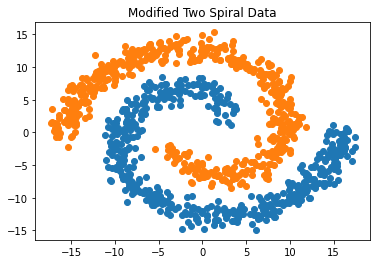

In [141]:
N = 500             # Number of data points per spiral
theta = np.sqrt(np.random.rand(N))*2*pi

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.title('Modified Two Spiral Data')
plt.show()

# np.savetxt("result.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')
np.savetxt("modifiedspirals.csv", res, delimiter=",", comments="", fmt='%.5f')



# Import created data from csv

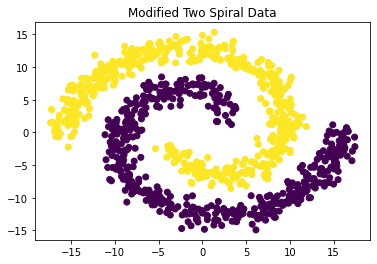

In [142]:
# Import generated data from file
def read_two_spiral_file(filename="modifiedspirals.csv"):
    x = []
    y = []
    
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            x.append(list(map(float, row[:-1])))
            y.append([float(v) for v in row[-1:]])

    return np.array(x), np.array(y)

x, y = read_two_spiral_file()       # x = inputs, y = response labels

spiral_x = [i[0] for i in x]        # spiral_x = x coordinates
spiral_y = [i[1] for i in x]        # spiral_y = y coordinates

# Plot using labels
plt.scatter(spiral_x, spiral_y, c=y)
plt.title('Modified Two Spiral Data')
plt.show()

# Split data into train and test sets

In [143]:
# Split the data set into training and testing
data_train, data_test, labels_train, labels_test = train_test_split(
    x, y, test_size=0.2, random_state=2)

# ANN Model

In [144]:
# Set network dimensions & layer sizes
inputs = data_train.shape[1]
layer1 = 16              
layer2 = 32             
outputs = 1 # Binary classification

In [145]:
# Build neural network
net = nn.Sequential(
    nn.Linear(inputs, layer1),
    nn.ELU(),
    nn.Linear(layer1, layer2),
    nn.ELU(),
    nn.Linear(layer2, outputs), nn.Sigmoid())

print(net)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)


In [146]:
# Set functions
loss_function = nn.BCELoss()
learning_rate = 0.1 
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [147]:
# Set iterations and number of plots shown
iterations = 1000                 
display_plot = 200         # controls iterations plotted

In [148]:
model_loss = []
model_accuracy = []

print('Shapes: ', labels_train.shape, labels_train.reshape(-1,1).shape)
y_torch = torch.FloatTensor(labels_train).reshape(-1, 1)

x_torch = torch.FloatTensor(data_train)
print('Shapes: ',x_torch.shape, y_torch.shape)

Shapes:  (800, 1) (800, 1)
Shapes:  torch.Size([800, 2]) torch.Size([800, 1])


In [149]:
# Plot decision boundary of model
def decision_boundary(x):               
	min_x, max_x = x[:, 0].min()-0.1, x[:, 0].max()+0.1
	min_y, max_y = x[:, 1].min()-0.1, x[:, 1].max()+0.1
	distance = min(max_x - min_x, max_y - min_y) / 100
	X, Y = np.meshgrid(np.arange(min_x, max_x, distance),np.arange(min_y, max_y, distance))
	input_data = np.hstack((X.ravel().reshape(-1,1),Y.ravel().reshape(-1,1)))
	input_data_torch = torch.FloatTensor(input_data)
	decision_prob = net(input_data_torch)
	decision = np.where(decision_prob<0.5,0,1)
	Z = decision.reshape(X.shape)
	return(plt.contourf(X, Y, Z, cmap=plt.cm.PiYG, alpha=0.6))

 Iteration:  0  Loss: 0.6257  Accuracy: 0.645


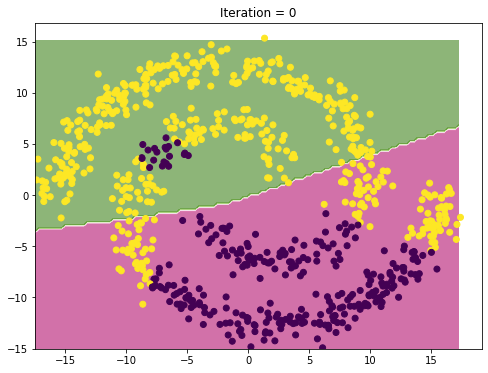

 Iteration:  200  Loss: 0.0002  Accuracy: 1.0


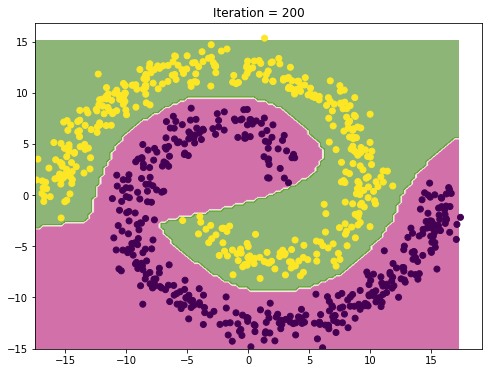

 Iteration:  400  Loss: 0.0001  Accuracy: 1.0


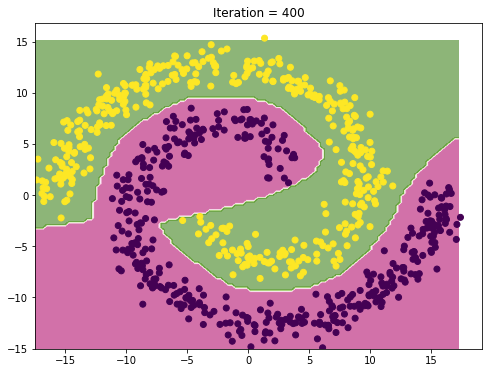

 Iteration:  600  Loss: 0.0000  Accuracy: 1.0


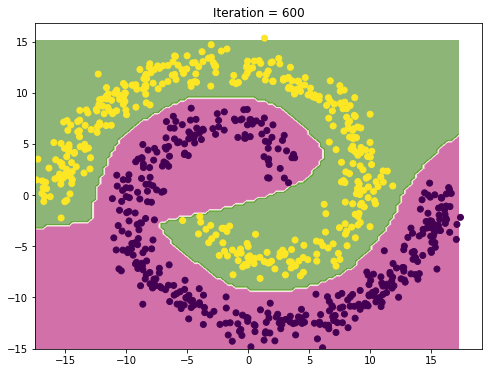

 Iteration:  800  Loss: 0.0000  Accuracy: 1.0


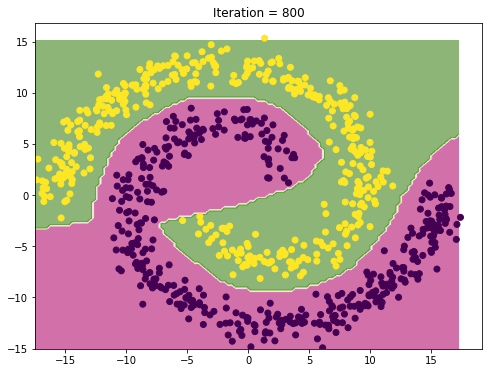

In [150]:
for i in range(iterations):
    y_class = net(x_torch)    # predict
    y_class_round = y_class.round()

    loss = loss_function(y_class,y_torch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    y_class_class = np.where(y_class.detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(labels_train.reshape(-1,1)==y_class_class) / len(labels_train)
    model_accuracy.append(accuracy)
    model_loss.append(loss.item())

    if i%display_plot == 0:
    	print(' Iteration: ', i, ' Loss: {:.4f}'.format(loss.item()),' Accuracy:', accuracy)
    	y_class_final =  y_class_round.detach().numpy().reshape(len(labels_train)) 
    	header = 'Iteration = {}'.format(i)
    	plt.figure(figsize=(8,6))
    	plt.title(header)
    	decision_boundary(data_train)
    	plt.scatter(data_train[:,0], data_train[:,1], c=y_class_final)

    	plt.show(block=False)
    	plt.pause(0.2)
    	plt.close()

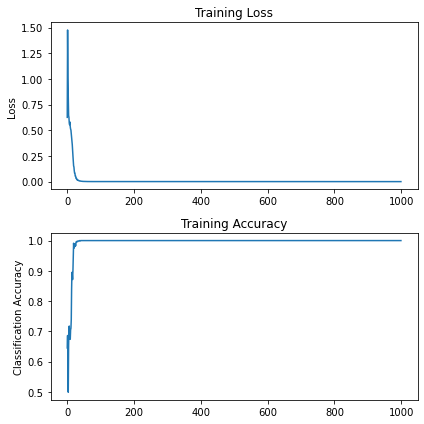

In [151]:
x_test_torch = torch.FloatTensor(data_test)
y_test_torch = torch.FloatTensor(labels_test).reshape(-1, 1)
y_class = net(x_test_torch)
loss_test = loss_function(y_class,y_test_torch)

fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(model_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(model_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

# Test the model

##############################
Training Accuracy: 1.000
Training Loss: 0.000
Test Accuracy: 1.000
Test Loss: 0.001
##############################
Test Results:
Prediction Accuracy 1.0
Macro Precision 1.0
Micro Precision 1.0
Macro Recall 1.0
Micro Recall 1.0


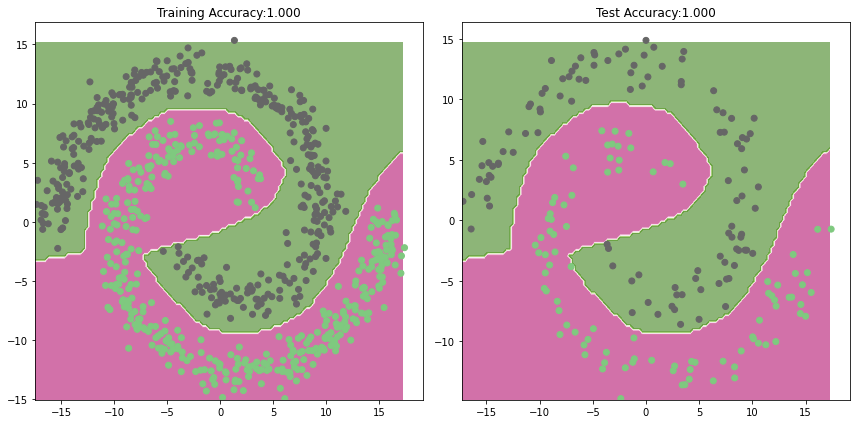

In [152]:
# Pass test data
x_test_torch = torch.FloatTensor(data_test)
y_class_test = net(x_test_torch)
y_class_test_final = np.where(y_class_test.detach().numpy()<0.5, 0, 1)
test_accuracy = np.sum(labels_test.reshape(-1,1)==y_class_test_final) / len(labels_test)

print('##############################')
print('Training Accuracy: {:.3f}'.format(accuracy))
print('Training Loss: {:.3f}'.format(loss))
print('Test Accuracy: {:.3f}'.format(test_accuracy))
print('Test Loss: {:.3f}'.format(loss_test))
print('##############################')

predictions = [] #
labels = [] #
predictions.append(y_class_test) #
labels.append(labels_test) #
predict_y = torch.cat(predictions).round() #
labels_test_out = y_torch #
print ('Test Results:')
print ('Prediction Accuracy', accuracy_score(labels_test.data, predict_y.data))
print ('Macro Precision', precision_score(labels_test.data, predict_y.data, average='macro'))
print ('Micro Precision', precision_score(labels_test.data, predict_y.data, average='micro'))
print ('Macro Recall', recall_score(labels_test.data, predict_y.data, average='macro'))
print ('Micro Recall', recall_score(labels_test.data, predict_y.data, average='micro'))

y_class_round = y_class_test.round()
y_class_final = y_class_round.detach().numpy().reshape(200)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Training Accuracy:{:.3f}'.format(accuracy))

_ = decision_boundary(data_train)
plt.scatter(data_train[:,0], data_train[:,1], c=labels_train,cmap=plt.cm.Accent)

plt.subplot(1,2,2)
plt.title('Test Accuracy:{:.3f}'.format(test_accuracy))

_ = decision_boundary(data_test)
plt.scatter(data_test[:,0], data_test[:,1], c=y_class_final,cmap=plt.cm.Accent)
plt.tight_layout()
plt.show()

In [153]:
print("Classification report: ANN Model")
print()

print(classification_report(labels_test.data, predict_y.data))
print()


print("Confusion Matrix: SVM Model")
print()
print(confusion_matrix(labels_test.data, predict_y.data))


Classification report: ANN Model

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       1.00      1.00      1.00       108

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix: SVM Model

[[ 92   0]
 [  0 108]]


# SVM Model

In [155]:
#set up parameters to iterate over
parameters = {'kernel':('linear', 'rbf'),
                'C':[0.0001, 0.001, 0.01, 0.1, 1],
                'gamma':[0.0001, 0.001, 0.01, 0.1, 1]
              }
clf = GridSearchCV(SVC(), parameters)
clf.fit(data_train, labels_train.flatten()) #iterate over all configurations
print("Best parameters:", clf.best_params_)

Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [156]:
# Fit best parameters to training data
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(data_train, labels_train.flatten())
accuracy = svm.score(data_train, labels_train)
print('Model train accuracy:',accuracy*100,'%')

Model train accuracy: 100.0 %


In [157]:
# Test model using test data
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(data_train, labels_train.flatten())
accuracy = svm.score(data_test, labels_test)
print('Model test accuracy:',accuracy*100,'%')

Model test accuracy: 100.0 %


# Visualise SVM Models

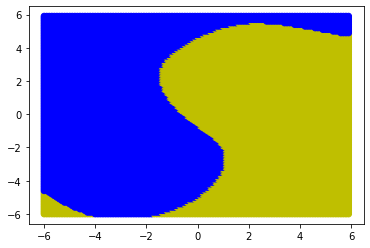

In [158]:
# Visualise activations
activation_range = arange(-6, 6, 0.1) # interval of [-6,6) with step size 0.1
coordinates = [(x,y) for x in activation_range for y in activation_range]
classifications = svm.predict(coordinates)
x, y = meshgrid(activation_range, activation_range)
plt.scatter(x, y, c=['b' if x > 0 else 'y' for x in classifications])
plt.show()

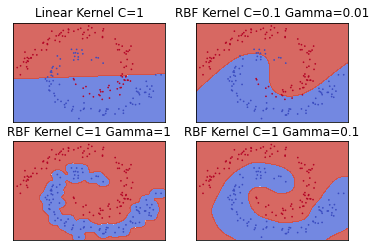

In [159]:
from sklearn.svm import SVC

X = data_test
y = labels_test.flatten()

SVM = SVC(kernel='linear', C=1).fit(X, y)
rbf_SVM_1 = SVC(kernel='rbf', gamma=0.01, C=0.1).fit(X, y)
rbf_SVM_2 = SVC(kernel='rbf', gamma=1, C=1).fit(X, y)
rbf_SVM_final = SVC(kernel='rbf', gamma=0.1, C=1).fit(X, y)

# create mesh
h = .02  # mesh step size
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# plot titles
titles = ['Linear Kernel C=1',
          'RBF Kernel C=0.1 Gamma=0.01',
          'RBF Kernel C=1 Gamma=1',
          'RBF Kernel C=1 Gamma=0.1']

for i, clf in enumerate((SVM, rbf_SVM_1, rbf_SVM_2, rbf_SVM_final)):
    # Plot decision boundary
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # Plot training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=0.5, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

In [160]:
print("Classification report: SVM Model")
print()

y_true, y_pred = labels_test, svm.predict(data_test)
print(classification_report(y_true, y_pred))
print()


print("Confusion Matrix: SVM Model")
print()
print(confusion_matrix(y_true, y_pred))


# Split the data set into training and testing
#data_train, data_test, labels_train, labels_test = train_test_split(x, y, test_size=0.2, random_state=2)

Classification report: SVM Model

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       1.00      1.00      1.00       108

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix: SVM Model

[[ 92   0]
 [  0 108]]
